In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, datetime

import nibabel as nib
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import zoom

from nitorch.data import load_nifti
from settings import settings
from tabulate import tabulate

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Binary brain mask used to cut out the skull.
mask = load_nifti(settings["binary_brain_mask"])

In [4]:
# set random state seed
r = 43

In [ ]:
data_table = "PATH/TO/YOUR/MODIFIED/ADNI_MERGE"

In [5]:
df = pd.read_csv(data_table)

### Clean the data table

In [6]:
# Sometimes pre-processing fails and we removed
# failed pre-processing in 067_S_0077/Screening 

failed_idx = list(df.loc[(df["PTID"]=="067_S_0077") & (df["Visit"] == "Screening")].index)
df = df.drop(index=failed_idx)

In [7]:
# remove all MCI subjects
df = df[df['DX'] != 'MCI']

In [9]:
def print_df_stats(df, df_train, df_val, df_test):
    """Print some statistics about the patients and images in a dataset."""
    headers = ['Images', '-> AD', '-> CN', 'Patients', '-> AD', '-> CN']

    def get_stats(df):
        df_ad = df[df['DX'] == 'Dementia']
        df_cn = df[df['DX'] == 'CN']
        return [len(df), len(df_ad), len(df_cn), len(df['PTID'].unique()), len(df_ad['PTID'].unique()), len(df_cn['PTID'].unique())]

    stats = []
    stats.append(['All'] + get_stats(df))
    stats.append(['Train'] + get_stats(df_train))
    stats.append(['Val'] + get_stats(df_val))
    stats.append(['Test'] + get_stats(df_test))

    print(tabulate(stats, headers=headers))
    print()

In [10]:
# Patient-wise train-test-split.
# Select a number of subjects for each class, put all their images in the test set 
# and all other images in the train set. This is the split that is used in the paper to produce the heatmaps.
test_subjects_per_class = 30
val_subjects_per_class = 18

subjects_AD = df[df['DX'] == 'Dementia']['PTID'].unique()
subjects_CN = df[df['DX'] == 'CN']['PTID'].unique()
subjects_CN = [p for p in subjects_CN if p not in subjects_AD]  # subjects that have both a CN and an AD scan should belong to the AD group

subjects_AD_train, subjects_AD_test = train_test_split(subjects_AD, test_size=test_subjects_per_class, random_state=r)
subjects_AD_train, subjects_AD_val = train_test_split(subjects_AD_train, test_size=val_subjects_per_class, random_state=r)
subjects_CN_train, subjects_CN_test = train_test_split(subjects_CN, test_size=test_subjects_per_class, random_state=r)
subjects_CN_train, subjects_CN_val = train_test_split(subjects_CN_train, test_size=val_subjects_per_class, random_state=r)

subjects_train = np.concatenate([subjects_AD_train, subjects_CN_train])
subjects_val = np.concatenate([subjects_AD_val, subjects_CN_val])
subjects_test = np.concatenate([subjects_AD_test, subjects_CN_test])

# Compile train and val dfs based on subjects.
df_train = df[df.apply(lambda row: row['PTID'] in subjects_train, axis=1)]
df_val = df[df.apply(lambda row: row['PTID'] in subjects_val, axis=1)]
df_test = df[df.apply(lambda row: row['PTID'] in subjects_test, axis=1)]

print_df_stats(df, df_train, df_val, df_test)

         Images    -> AD    -> CN    Patients    -> AD    -> CN
-----  --------  -------  -------  ----------  -------  -------
All         969      475      494         344      193      151
Train       697      360      337         248      145      103
Val         100       40       60          36       18       18
Test        172       75       97          60       30       30



In [11]:
# load images in matrix
def create_dataset(dataset, z_factor, mask=None):
    data_matrix = [] 
    labels = [] 
    for idx, row in dataset.iterrows():
        path = row["filepath"]
        struct_arr = np.NAN
        scan = nib.load(path)
        struct_arr = scan.get_data().astype(np.float32)
        if mask is not None:
            struct_arr *= mask
        if z_factor is not None:
            struct_arr = zoom(struct_arr, z_factor)
        data_matrix.append(struct_arr)
        labels.append((row["DX"] == "Dementia") *1)      
    return np.array(data_matrix), np.array(labels)

In [9]:
z_factor = None

In [10]:
print("Starting at " + time.ctime())
start = time.time()

print("Train dataset..")
train_dataset, train_labels = create_dataset(df_train, z_factor=z_factor, mask=mask)
print("Time elapsed: " + str(datetime.timedelta(seconds=(time.time()-start))))
print("Validation dataset..")
val_dataset, val_labels = create_dataset(df_val, z_factor=z_factor, mask=mask)
print("Time elapsed: " + str(datetime.timedelta(seconds=(time.time()-start))))
print("Holdout dataset..")
holdout_dataset, holdout_labels = create_dataset(df_test, z_factor=z_factor, mask=mask)

end = time.time()
print("Runtime: " + str(datetime.timedelta(seconds=(end-start))))


Starting at Fri May 24 14:48:48 2019
Train dataset..
Time elapsed: 0:15:50.849694
Validation dataset..
Time elapsed: 0:17:59.846478
Holdout dataset..
Runtime: 0:21:22.336500


In [11]:
print(train_dataset.shape)
print(val_dataset.shape)
print(holdout_dataset.shape)

(697, 193, 229, 193)
(100, 193, 229, 193)
(172, 193, 229, 193)


In [12]:
import matplotlib.pyplot as plt

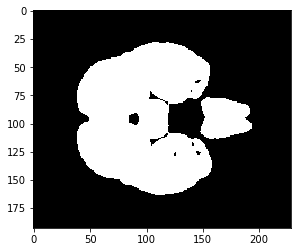

In [13]:
plt.imshow(mask[:,:,50], cmap='gray')
plt.show()

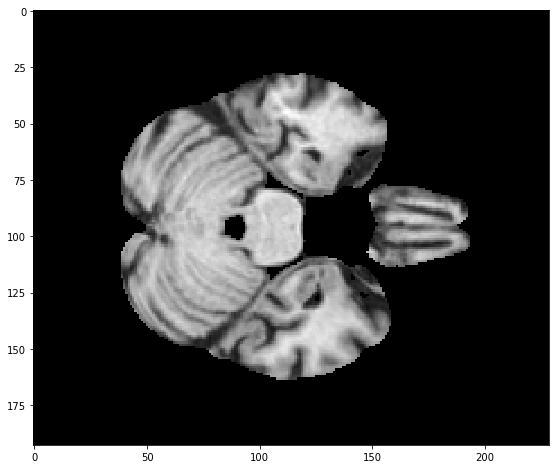

In [14]:
plt.figure(figsize=(12, 8))
plt.imshow(train_dataset[-1][:,:,50], cmap='gray')
plt.show()

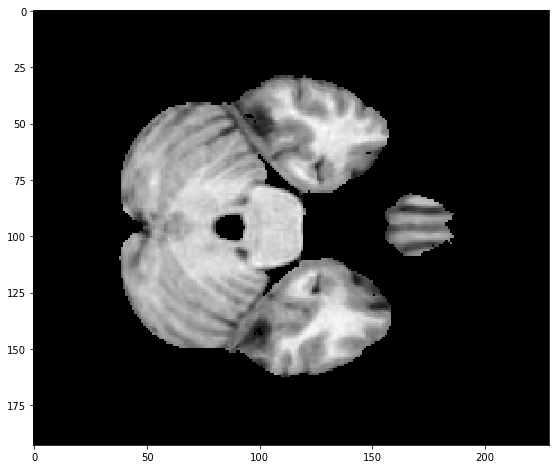

In [15]:
plt.figure(figsize=(12, 8))
plt.imshow(holdout_dataset[6][:,:,48], cmap='gray')
plt.show()

In [22]:
import h5py

In [23]:
h5 = h5py.File(settings["train_h5"], 'w')
h5.create_dataset('X', data=train_dataset, compression='gzip', compression_opts=9)
h5.create_dataset('y', data=train_labels, compression='gzip', compression_opts=9)
h5.close()

In [24]:
h5 = h5py.File(settings["val_h5"], 'w')
h5.create_dataset('X', data=val_dataset, compression='gzip', compression_opts=9)
h5.create_dataset('y', data=val_labels, compression='gzip', compression_opts=9)
h5.close()

In [25]:
h5 = h5py.File(settings["holdout_h5"], 'w')
h5.create_dataset('X', data=holdout_dataset, compression='gzip', compression_opts=9)
h5.create_dataset('y', data=holdout_labels, compression='gzip', compression_opts=9)
h5.close()

In [ ]:
quit()